In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [12]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

transform = transforms.ToTensor()

full_train_dataset = datasets.MNIST(
    root='../data',
    train=True,
    transform=transform,
    download=False  # Don't download again
)

train_dataset, val_dataset = random_split(full_train_dataset, [50000, 10000])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=8)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [85]:
conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, 2, 1),
            nn.PReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.PReLU(),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.PReLU(),
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.PReLU(),
            nn.Flatten()
        )

linear = nn.Sequential(
            nn.Linear(2304, 512),
            nn.PReLU(),
            nn.Linear(512, 128)
        )

linear2 = nn.Sequential(
    nn.Linear(128, 512),
    nn.PReLU(),
    nn.Linear(512, 2304),
    nn.PReLU(),
    nn.Unflatten(dim=1, unflattened_size=(256, 3, 3))
)

# Transposed convolutional layers
deconv = nn.Sequential(
    nn.ConvTranspose2d(256, 128, 3, 2, 1, 1),
    nn.PReLU(),
    nn.ConvTranspose2d(128, 64, 3, 2, 1, 1),
    nn.PReLU(),
    nn.ConvTranspose2d(64, 32, 3, 2, 1),
    nn.PReLU(),
    nn.ConvTranspose2d(32, 1, 3, 2, 1),
    nn.Sigmoid()
)

In [65]:
r = torch.randn((1, 1, 45 , 45))

In [86]:
x = conv(r)
x = linear(x)
x = linear2(x)
x = deconv(x)

In [87]:
x.shape

torch.Size([1, 1, 45, 45])

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, 2, 1),  # 28 → 14
            nn.PReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),  # 14 → 7
            nn.PReLU(),
            nn.Conv2d(64, 128, 3, 2, 1), # 7 -> 4
            nn.Flatten()
        )
        
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar


class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 64 * 7 * 7)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1),  # 7 → 14
            nn.PReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),   # 14 → 28
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.fc(z).view(z.size(0), 64, 7, 7)
        return self.deconv(x)

def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

In [ ]:
def loss_fn(x_recon, x, mu, logvar):
    recon_loss = nn.functional.binary_cross_entropy(x_recon, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl

model = VAE(latent_dim=20).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses = []
for epoch in range(1, 30):
    model.train()
    total_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        x_recon, mu, logvar = model(x)
        loss = loss_fn(x_recon, x, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    
    print(f"Epoch {epoch}, Loss: {total_loss / len(train_loader.dataset):.4f}")

Epoch 1, Loss: 140.9100
Epoch 2, Loss: 112.6711
Epoch 3, Loss: 108.4882
Epoch 4, Loss: 106.5586
Epoch 5, Loss: 105.4326
Epoch 6, Loss: 104.5777
Epoch 7, Loss: 103.9755
Epoch 8, Loss: 103.4911
Epoch 9, Loss: 103.0451
Epoch 10, Loss: 102.6629
Epoch 11, Loss: 102.3443
Epoch 12, Loss: 102.0725
Epoch 13, Loss: 101.8451
Epoch 14, Loss: 101.6511
Epoch 15, Loss: 101.3973
Epoch 16, Loss: 101.2317
Epoch 17, Loss: 101.0393
Epoch 18, Loss: 100.9244
Epoch 19, Loss: 100.7432
Epoch 20, Loss: 100.6105
Epoch 21, Loss: 100.5195
Epoch 22, Loss: 100.4097
Epoch 23, Loss: 100.3330
Epoch 24, Loss: 100.2058
Epoch 25, Loss: 100.0590
Epoch 26, Loss: 99.9767
Epoch 27, Loss: 99.8931
Epoch 28, Loss: 99.7987
Epoch 29, Loss: 99.6933


In [19]:
import matplotlib.pyplot as plt

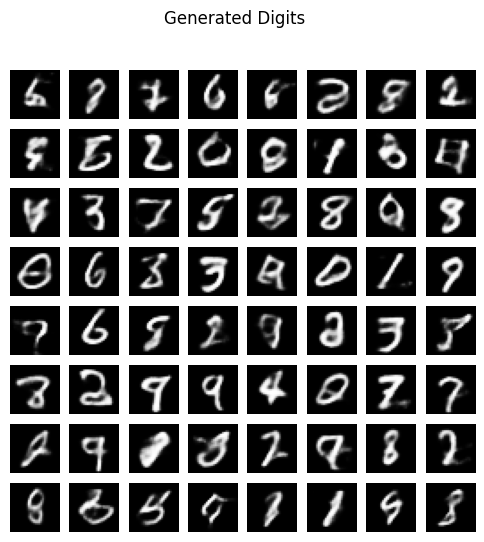

In [20]:
model.eval()
with torch.no_grad():
    z = torch.randn(64, 20).to(device)  # 64 samples from latent space
    generated = model.decoder(z).cpu()

# Plot 8x8 grid
fig, axes = plt.subplots(8, 8, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated[i][0], cmap='gray')
    ax.axis('off')
plt.suptitle("Generated Digits")
plt.show()

### Deblending

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        filters = [32, 64, 128, 256]
        kernel_size = [3, 3, 3, 3]
        num_bands = 1
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(num_bands, filters[0], kernel_size=kernel_size[0], stride=2, padding=1) # 45x45 → 23x23
        self.conv2 = nn.Conv2d(filters[0], filters[1], kernel_size=kernel_size[1], stride=2, padding=1)   # 23x23 → 12x12
        self.conv3 = nn.Conv2d(filters[1], filters[2], kernel_size=kernel_size[2], stride=2, padding=1)   # 12x12 → 6x6
        self.conv4 = nn.Conv2d(filters[2], filters[3], kernel_size=kernel_size[3], stride=2, padding=1)   # 6x6 → 3x3

        # PReLU activation layers
        self.prelu1 = nn.PReLU()
        self.prelu2 = nn.PReLU()
        self.prelu3 = nn.PReLU()
        self.prelu4 = nn.PReLU()
        self.prelu_fc1 = nn.PReLU()

        # Fully connected layers
        self.fc1 = nn.Linear(3 * 3 * filters[3], 512) # 2304 -> 512
        self.fc2 = nn.Linear(512, 128) # 512 -> 128
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

    def forward(self, x):
        x = x.to(device)

        # Apply Conv -> PReLU 
        x = self.prelu1(self.conv1(x))  # 45x45 → 23x23
        x = self.prelu2(self.conv2(x))  # 23x23 → 12x12
        x = self.prelu3(self.conv3(x))  # 12x12 → 6x6
        x = self.prelu4(self.conv4(x))  # 6x6 → 3x3
        
        # Flatten
        x = torch.flatten(x, start_dim=1)

        # Fully connected layers
        x = self.prelu_fc1(self.fc1(x))    
        x = self.fc2(x)                    
    
        # Latent distribution
        mu = self.fc_mu(x)                 # Mean of latent distribution
        logvar = self.fc_logvar(x)         # Log variance of latent distribution

        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        filters = [32, 64, 128, 256]
        kernel_size = [3, 3, 3, 3]
        num_bands = 1

        self.prelu_fc1 = nn.PReLU()
        self.prelu_fc2 = nn.PReLU()
        self.prelu_fc3 = nn.PReLU()
        self.prelu1 = nn.PReLU()
        self.prelu2 = nn.PReLU()
        self.prelu3 = nn.PReLU()
        self.sigmoid = nn.Sigmoid()

        # Fully connected layers
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, 512)
        self.fc3 = nn.Linear(512, 3 * 3 * filters[3])

        # Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(filters[3], 3, 3))

        # Transposed convolutional layers
        self.deconv1 = nn.ConvTranspose2d(filters[3], filters[2], kernel_size=kernel_size[0], stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(filters[2], filters[1], kernel_size=kernel_size[1], stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(filters[1], filters[0], kernel_size=kernel_size[2], stride=2, padding=1, output_padding=1)
        self.deconv4 = nn.ConvTranspose2d(filters[0], num_bands, kernel_size=kernel_size[3], stride=2, padding=1, output_padding=1)

    def forward(self, x):
        x = x.to(device)
        # Fully connected
        x = self.prelu_fc1(self.fc1(x))
        x = self.prelu_fc2(self.fc2(x))
        x = self.prelu_fc3(self.fc3(x))

        # Reshape to 3D
        x = self.unflatten(x)

        # Deconvolutional layers
        x = self.prelu1(self.deconv1(x))
        x = self.prelu2(self.deconv2(x))
        x = self.prelu3(self.deconv3(x))
        x = self.deconv4(x)

        x = cropping(x, output_size=45) # Cropping
        
        x = self.sigmoid(x)
        return x

class VAE(nn.Module):
    def __init__(self, latent_dims):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z, kl = reparameterization(mu, logvar)

        return self.decoder(z), kl

In [ ]:
from vae import VAE, SimpleBlendDataset, generated_images, plot_loss_function, loss_function, save_model, save_checkpoint, train_epoch, test_epoch

import torch
from torch.utils.data import DataLoader, random_split
import numpy as np
import os

# Setup
latent_dims = 32
name = "test_sigmoid"
num_epochs = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vae = VAE(latent_dims).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# Load data
SCRATCH = os.getenv("ALL_CCFRSCRATCH")
train_path = os.path.join(SCRATCH, "deblending/isolated/isolated_training_9_arcs")
dataset = SimpleBlendDataset(base_path=train_path, num_files=100) # Number of images in dataset = num_files * 1000

# Dividing 80% for training and 20% for valuation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=8, # Parallel loading
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=8,
    pin_memory=True if torch.cuda.is_available() else False
)

# Training loop
train_loss = np.empty(num_epochs)
val_loss = np.empty(num_epochs)
train_mse = np.empty(num_epochs)
val_mse = np.empty(num_epochs)
train_kl = np.empty(num_epochs)
val_kl = np.empty(num_epochs)

for epoch in range(num_epochs):
    train_loss[epoch], train_mse[epoch], train_kl[epoch] = train_epoch(vae, device, train_loader, optimizer)
    val_loss[epoch], val_mse[epoch], val_kl[epoch] = test_epoch(vae, device, val_loader)
    if (epoch + 1) % 10 == 0: # Save checkpoint every 10 epoch
        save_checkpoint(epoch, vae, optimizer, train_loss[:epoch+1], train_mse[:epoch+1], train_kl[:epoch+1], val_loss[:epoch+1], val_mse[:epoch+1], val_kl[:epoch+1], f"checkpoints/vae_checkpoint_{name}.pth")

# Save and plot
save_model(epoch, vae, optimizer, train_loss, train_mse, train_kl, val_loss, val_mse, val_kl, f"models/vae_model_{name}.pth")
plot_loss_function(num_epochs, train_loss, val_loss, name)
generated_images(vae, latent_dims, name)